In [8]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from keras.utils import plot_model
from training import train, create_training_folder, create_callbacks, step_decay_exp
from tcn import TCN, tcn_full_summary

import keras.backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tcn_mod import TCN

from tensorflow.keras.layers import Embedding, Dense, Input, Bidirectional, LSTM,\
    BatchNormalization, GlobalAveragePooling1D, Activation, Dropout, SpatialDropout1D, RepeatVector,\
    TimeDistributed

from tensorflow.keras.models import Model,Sequential
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.regularizers import l1, l2

from training import train, create_training_folder

    

In [2]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [4]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 11]
X = sample[:, 3:11]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
y = to_categorical(y)
# random train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    

print(np.unique(y_train).shape)

print("===Train/test size: {}, {}".format(len(y_train), len(y_test)))

Using sample size: (31373, 12)
(2,)
===Train/test size: 21961, 9412


In [5]:
crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["idx"].values.tolist()

In [18]:


def tcn(sequence_length, embeddings, layer_size = 256):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_size,  input_length=sequence_length))
    model.add(SpatialDropout1D(0.2)) ##This
    model.add(LSTM(units = layer_size, recurrent_dropout=0.4))
    model.add(RepeatVector(sequence_length))
    model.add(LSTM(units = layer_size))
    model.add(Dense(27, activation = "relu"))

    return model
    


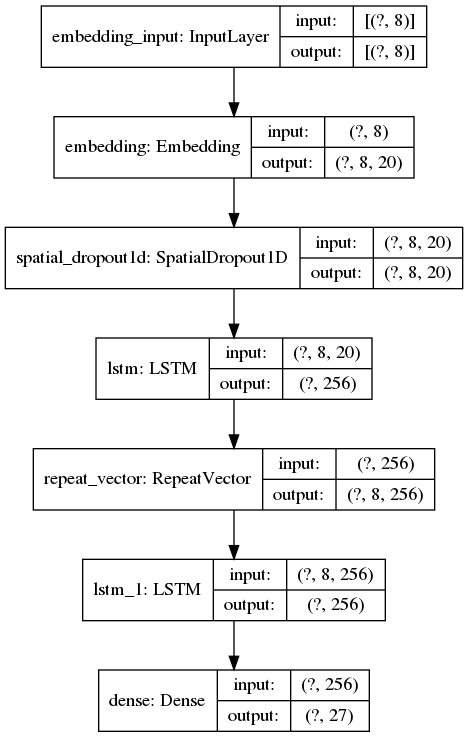

In [19]:

K.clear_session()
sequence_length = 8
vocab_size, embedding_size = (27, 20)
# model = hydrid(sequence_length, (vocab_size, embedding_size))
model = tcn(sequence_length, (vocab_size, embedding_size))

tag = "repeat_lstm"

plot_model(model, show_shapes = True)

In [20]:
K.clear_session()

training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)

epochs=100
exp_base = "tcnv3"
folder = create_training_folder(exp_base, tag)

# lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)


train(model, X_train, y_train, X_test, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)



/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


Epoch 1/100

Epoch 00001: val_f1 improved from -inf to 0.42963, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200808_085345_repeat_lstm
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200808_085345_repeat_lstm/assets
687/687 - 44s - loss: 0.7193 - f1: 0.2808 - val_loss: 0.5700 - val_f1: 0.4296
Epoch 2/100

Epoch 00002: val_f1 improved from 0.42963 to 0.49774, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200808_085345_repeat_lstm
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200808_085345_repeat_lstm/assets
687/687 - 44s - loss: 0.5380 - f1: 0.4619 - val_loss: 0.5010 - val_f1: 0.4977
Epoch 3/100

Epoch 00003: val_f1 improved from 0.49774 to 0.55470, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200808_085345_repeat_lstm
INFO:tensorflow:Assets written to: /home/gu

Epoch 27/100

Epoch 00027: val_f1 improved from 0.68363 to 0.68772, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200808_085345_repeat_lstm
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200808_085345_repeat_lstm/assets
687/687 - 25s - loss: 0.3074 - f1: 0.6919 - val_loss: 0.3103 - val_f1: 0.6877
Epoch 28/100

Epoch 00028: val_f1 did not improve from 0.68772
687/687 - 21s - loss: 0.3044 - f1: 0.6952 - val_loss: 0.3129 - val_f1: 0.6854
Epoch 29/100

Epoch 00029: val_f1 did not improve from 0.68772
687/687 - 26s - loss: 0.3085 - f1: 0.6908 - val_loss: 0.3132 - val_f1: 0.6848
Epoch 30/100

Epoch 00030: val_f1 did not improve from 0.68772
687/687 - 21s - loss: 0.3082 - f1: 0.6913 - val_loss: 0.3186 - val_f1: 0.6795
Epoch 31/100

Epoch 00031: val_f1 improved from 0.68772 to 0.68971, saving model to /home/gus/workspaces/wpy/IACapstone/results/tcnv3/20200808_085345_repeat_lstm
INFO:tensorflow:Assets written to: /home/gus/workspaces

Epoch 70/100

Epoch 00070: val_f1 did not improve from 0.71406
687/687 - 35s - loss: 0.2551 - f1: 0.7444 - val_loss: 0.2857 - val_f1: 0.7125
Epoch 71/100

Epoch 00071: val_f1 did not improve from 0.71406
687/687 - 35s - loss: 0.2475 - f1: 0.7519 - val_loss: 0.2913 - val_f1: 0.7068
Epoch 72/100

Epoch 00072: val_f1 did not improve from 0.71406
687/687 - 34s - loss: 0.2506 - f1: 0.7487 - val_loss: 0.2928 - val_f1: 0.7051
Epoch 73/100

Epoch 00073: val_f1 did not improve from 0.71406
687/687 - 31s - loss: 0.2522 - f1: 0.7472 - val_loss: 0.2841 - val_f1: 0.7140
Epoch 74/100

Epoch 00074: val_f1 did not improve from 0.71406
687/687 - 35s - loss: 0.2494 - f1: 0.7497 - val_loss: 0.2907 - val_f1: 0.7074
Epoch 75/100

Epoch 00075: val_f1 did not improve from 0.71406
687/687 - 35s - loss: 0.2448 - f1: 0.7545 - val_loss: 0.2893 - val_f1: 0.7087
Epoch 76/100

Epoch 00076: val_f1 did not improve from 0.71406
687/687 - 35s - loss: 0.2462 - f1: 0.7533 - val_loss: 0.2905 - val_f1: 0.7074
Epoch 77/100


In [ ]:
# evaluate
y_hat = model.predict(X_test)
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)


In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)